In [ ]:

# Save figures in specific place

knitr::opts_chunk$set(autodep        = TRUE,
                      cache          = FALSE,
                      cache.comments = TRUE,

                      # Save figures as pdf ?
                      dev = c("png", "pdf"),

                      # Include code?
                      echo           = TRUE,
                      warning = FALSE,

                      error          = FALSE,
                      fig.align      = "center",

                      # Path where figures are going to be store pdf single
                      # figures
                      fig.path       = paste0("./figures", "/"),
                      fig.width      = 11,
                      fig.height     = 7,
                      message        = FALSE)

# set to two decimal
options(scipen = 1, digits = 4)

In [1]:
library(dplyr)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(here)
library(reactablefmtr)
library(reactable)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)
library(knitr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


here() starts at /home/ecamo19/Documents/projects/nutrients_and_water_effects_2022/physiolocal_responses_tropical_dry_forest_reproducible_stats

Loading required package: reactable

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘ggplot2’


The following object is masked from ‘package:reactablefmtr’:

    margin



Attaching package: ‘modelr’


The following objects are masked from ‘package:performance’:

    mae, m

In [2]:
# Set knit directory
setwd(here::here())
knitr::opts_knit$set(root.dir = setwd(here::here()))
getwd()

[1] "/home/ecamo19/Documents/projects/nutrients_and_water_effects_2022/physiolocal_responses_tropical_dry_forest_reproducible_stats"

# Load functions and data

In [3]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")

# Step was done like this because I am working with a subset of the data
# source cleaned data
source("./scripts/code_clean_data_nodules.R")


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




[1] "Files loaded: data_rgr_cleaned"
[1] "Files loaded: data_for_models"
[1] "Files loaded: data_for_models"      "Files loaded: data_nodules_cleaned"


In [4]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")

__Q2: How does increased nutrient and/or water availability influence seedling
water- and nutrient-use traits and the relationships with N-fixing bacteria?__

# Model fitting

## Traits

In [5]:
# Take response variables names
response_vars_q2 <-
  set_names(c("amax", "gs", "sla"))

In [6]:
## Create empty list
models_q2 <- list()

In [7]:
model_q2_amax <- lme(amax ~ nfixer*treatment +init_height,
                                        random = ~1|spcode,
                                        data = data_for_models)

model_q2_amax <- list(model_q2_amax)

names(model_q2_amax) <- "amax"



In [8]:
model_q2_gs <- lme(gs ~ nfixer*treatment +init_height,
                                        random = ~1|spcode,
                                        data = data_for_models)

model_q2_gs <- list(model_q2_gs)

names(model_q2_gs) <- "gs"


In [9]:
model_q2_sla <- lme(sla ~ nfixer*treatment +init_height,
                                        random = ~1|spcode,
                                        data = data_for_models)

model_q2_sla <- list(model_q2_sla)

names(model_q2_sla) <- "sla"                      

In [10]:
## PNUE
model_q2_pnue_log <- lme(log(pnue) ~ nfixer*treatment +init_height,
                                        random = ~1|spcode,
                                        data = data_for_models)

model_q2_pnue_log <- list(model_q2_pnue_log)

names(model_q2_pnue_log) <- "pnue_log"

In [11]:
model_q2_pnue_nlme <- lme(pnue ~ nfixer*treatment + init_height,
                                        random = ~1|spcode,
                                        weights = varIdent(form = ~1|spcode*treatment),
                                        data = data_for_models)

model_q2_pnue_nlme <- list(model_q2_pnue_nlme)

names(model_q2_pnue_nlme) <- "pnue_nlme"


In [12]:
## Narea_g_m2 log model
model_q2_n_area_log <- lme(log(narea_g_m2) ~ nfixer*treatment + init_height,
                                                random = ~1|spcode,
                                                data = data_for_models)

model_q2_n_area_log <- list(model_q2_n_area_log)

names(model_q2_n_area_log) <- "n_area_log"

In [13]:
model_q2_n_area_nlme <- lme(narea_g_m2 ~ nfixer*treatment + init_height,
                                        random = ~1|spcode,
                                        weights = varIdent(form = ~1|spcode*treatment),
                                        data = data_for_models)

model_q2_n_area_nlme <- list(model_q2_n_area_nlme)

names(model_q2_n_area_nlme) <- "n_area_nlme"


In [14]:
## WUE log model
model_q2_wue_log <- lme(log(wue) ~ nfixer*treatment + init_height,
                                        random = ~1|spcode,
                                        data = data_for_models)

model_q2_wue_log <- list(model_q2_wue_log)

names(model_q2_wue_log) <- "wue_log"

In [15]:
model_q2_wue_nlme <- lme(wue ~ nfixer*treatment + init_height,
                                        random = ~1|spcode,
                                        weights = varIdent(form = ~1|spcode*treatment),
                                        data = data_for_models)

model_q2_wue_nlme <- list(model_q2_wue_nlme)

names(model_q2_wue_nlme) <- "wue_nlme"

## Nodule colonization

In [16]:
# Delete unused variables
data_nodules_cleaned <-
    data_nodules_cleaned %>%

        # add id to rownames for keep track of the rows
        column_to_rownames("id") %>%
        dplyr::select(spcode, treatment, everything())

### Nodule weight

In [17]:
nlme_nodule_weight <- lme(estimated_total_nodule_mass_per_plant ~ treatment + init_height,
                                    random = ~1|spcode,
                                    weights = varIdent(form = ~1|spcode*treatment),
                                    data = data_nodules_cleaned)


model_q2_nodule_weight <- list(nlme_nodule_weight)

names(model_q2_nodule_weight) <- "nodule_weight"

### Nodule count

In [18]:
nlme_nodule_count <- lme(log(total_number_of_plant_nodules) ~ treatment + init_height,
                                    random = ~1|spcode,
                                    weights = varIdent(form = ~1|spcode),
                                    data = data_nodules_cleaned)

model_q2_nodule_count <- list(nlme_nodule_count)

names(model_q2_nodule_count) <- "nodule_count"

In [19]:
# Append models to model list
models_q2 <- append(model_q2_amax, models_q2)
models_q2 <- append(model_q2_gs, models_q2)
models_q2 <- append(model_q2_sla, models_q2)

models_q2 <- append(model_q2_n_area_log, models_q2)
models_q2 <- append(model_q2_n_area_nlme, models_q2)

models_q2 <- append(model_q2_pnue_log, models_q2)
models_q2 <- append(model_q2_pnue_nlme, models_q2)

models_q2 <- append(model_q2_wue_log, models_q2)
models_q2 <- append(model_q2_wue_nlme, models_q2)

models_q2 <- append(model_q2_nodule_count, models_q2)
models_q2 <- append(model_q2_nodule_weight, models_q2)

In [20]:
names(models_q2)

[1] "nodule_weight" "nodule_count"  "wue_nlme"      "wue_log"      
 [5] "pnue_nlme"     "pnue_log"      "n_area_nlme"   "n_area_log"   
 [9] "sla"           "gs"            "amax"

# Model Assumptions

## Maximal photosynthesis

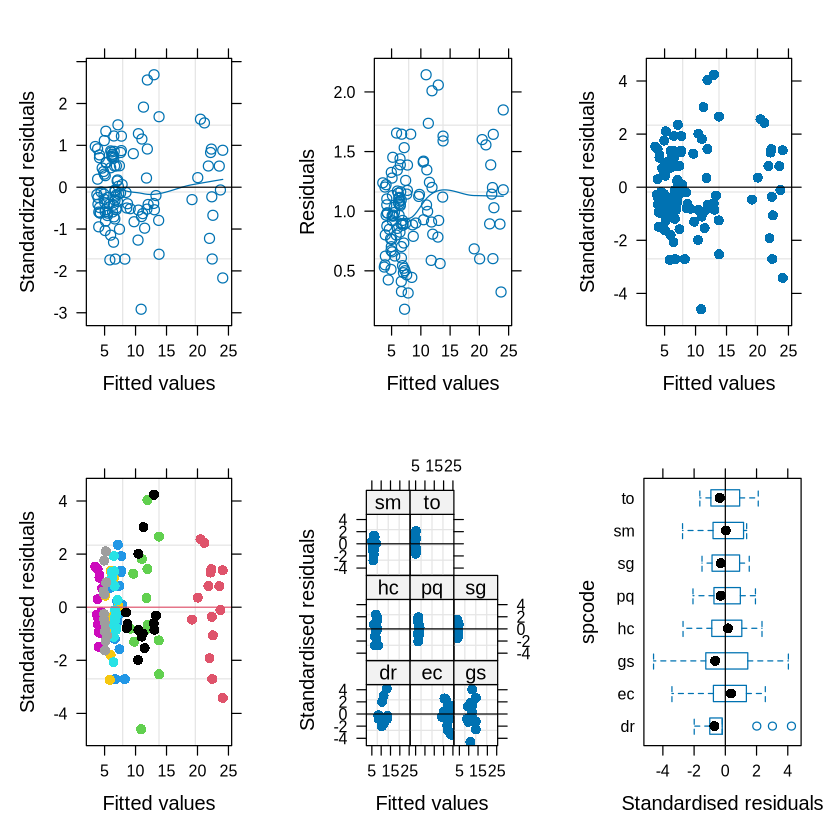

In [21]:
validation_plots(models_q2$amax, data = data_for_models, group = "spcode")

## Stomatal Conductance

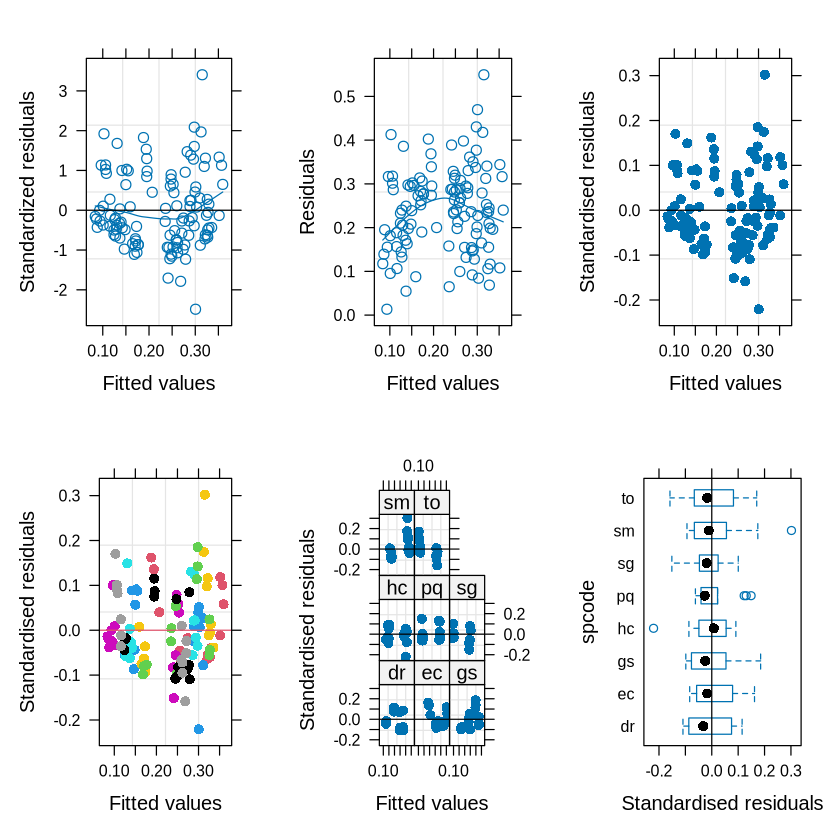

In [22]:
validation_plots(models_q2$gs, data = data_for_models, group = "spcode")

## SLA

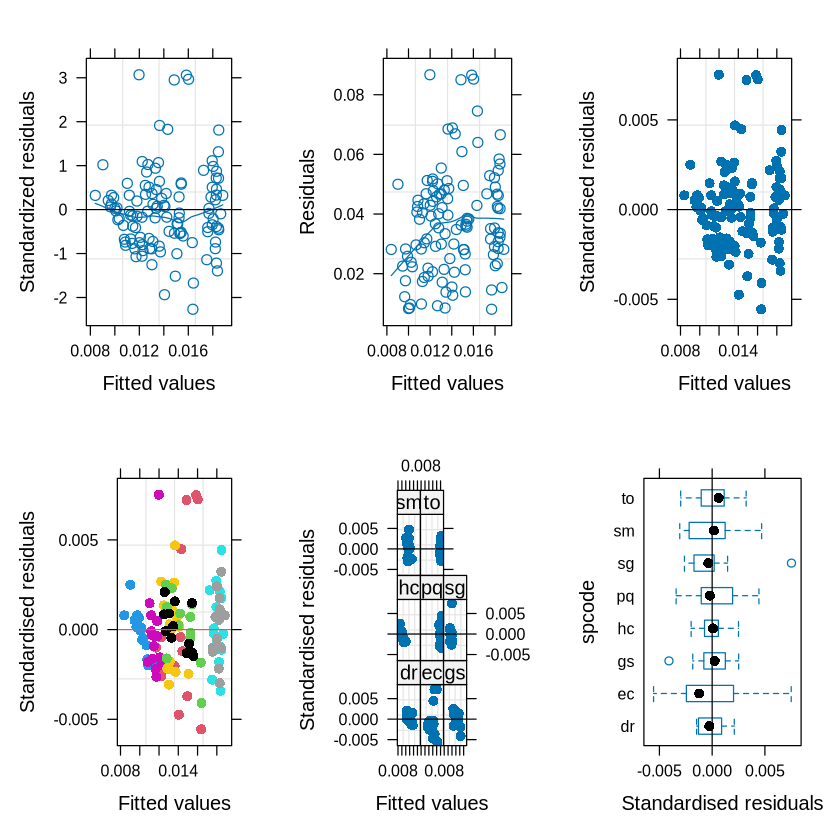

In [23]:
validation_plots(models_q2$sla, data = data_for_models, group = "spcode")

## Water Use Efficiency

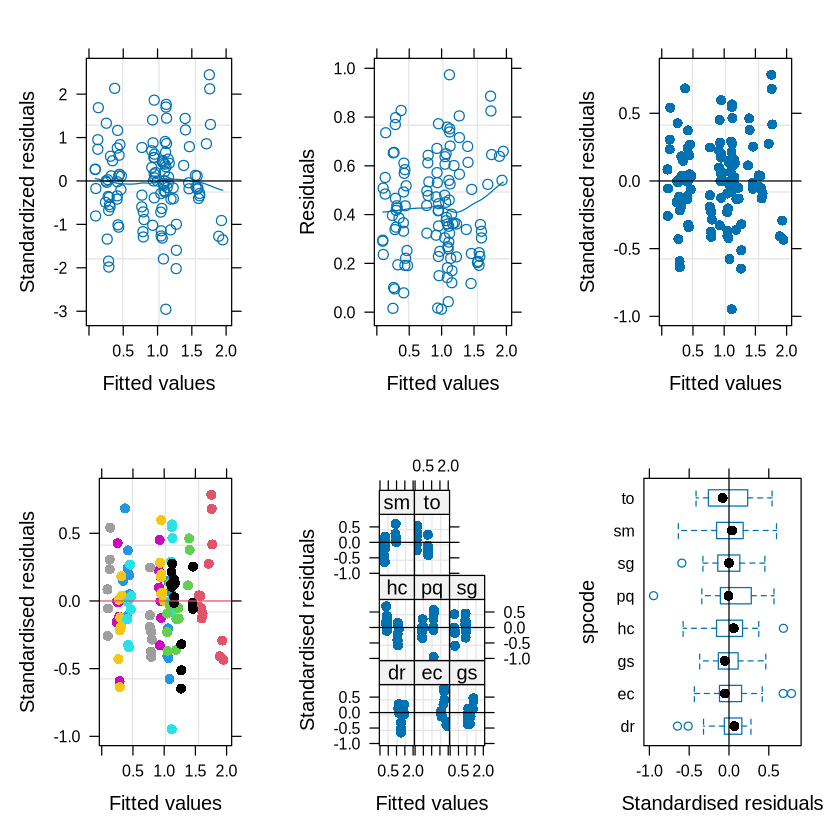

In [24]:
validation_plots(models_q2$wue_log, data = data_for_models, group = "spcode")

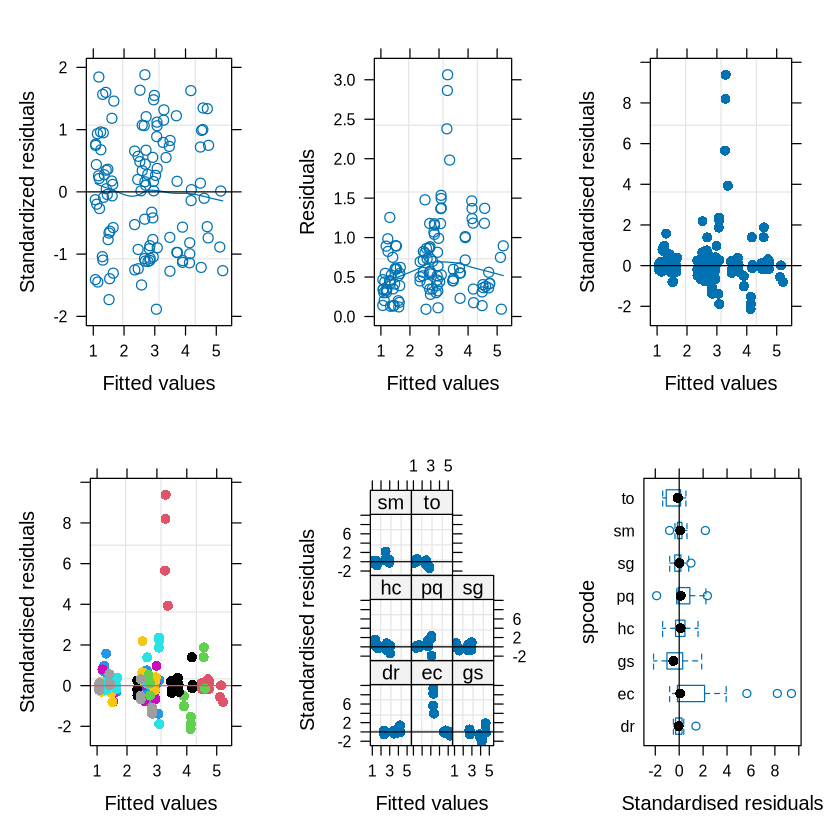

In [25]:
validation_plots(models_q2$wue_nlme, data = data_for_models, group = "spcode")

## PNUE

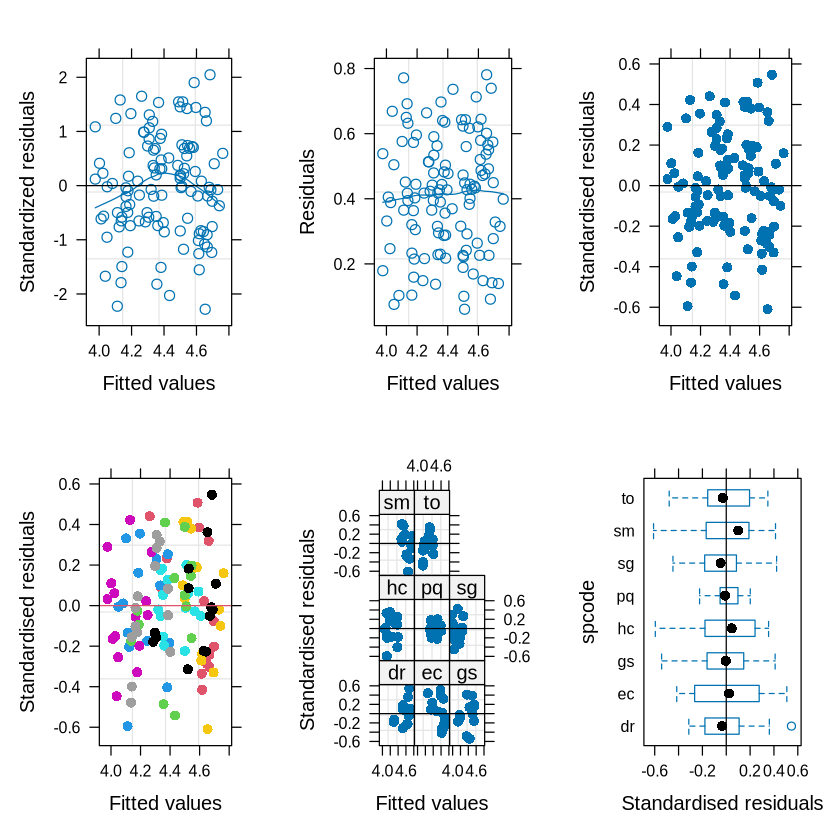

In [26]:
validation_plots(models_q2$pnue_log, data = data_for_models, group = "spcode")

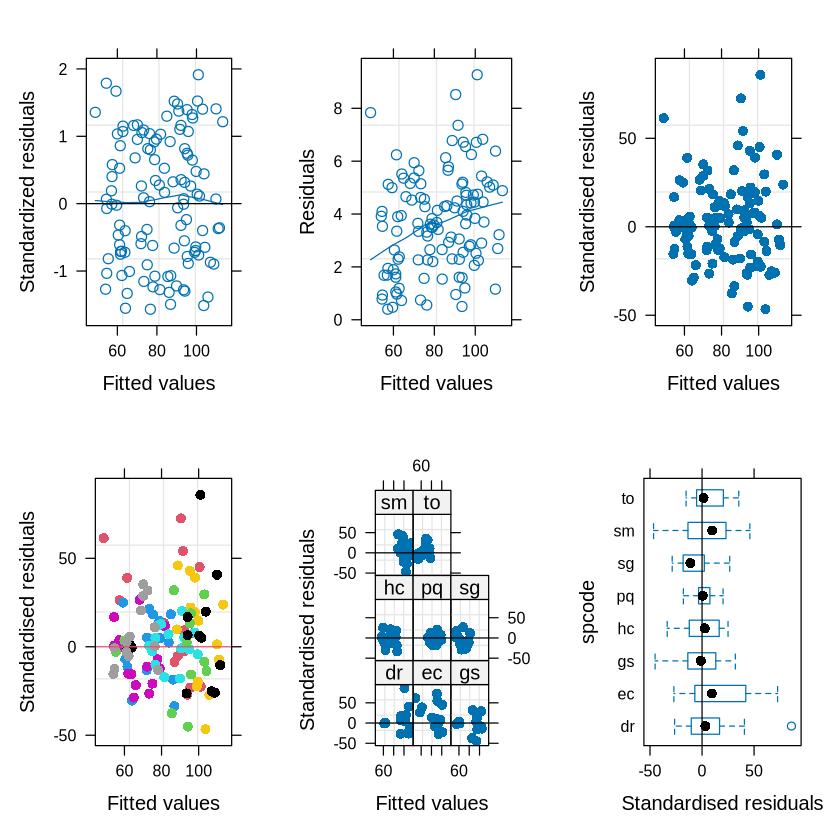

In [27]:
validation_plots(models_q2$pnue_nlme, data = data_for_models, group = "spcode")

## Nitrogen concentration per unit of area

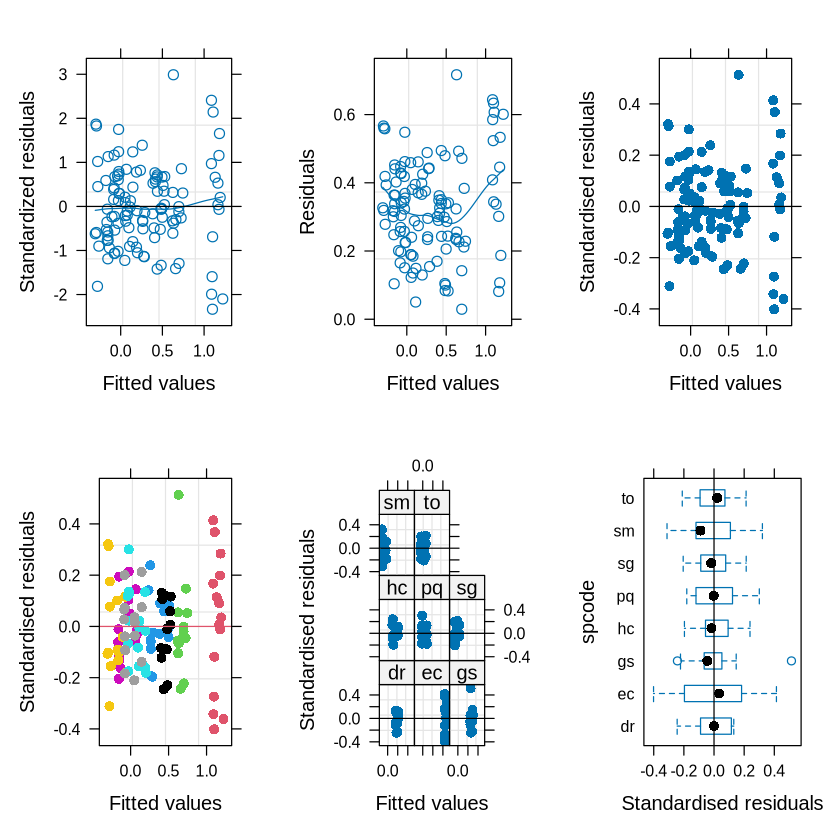

In [28]:
validation_plots(models_q2$n_area_log, data = data_for_models, group = "spcode")

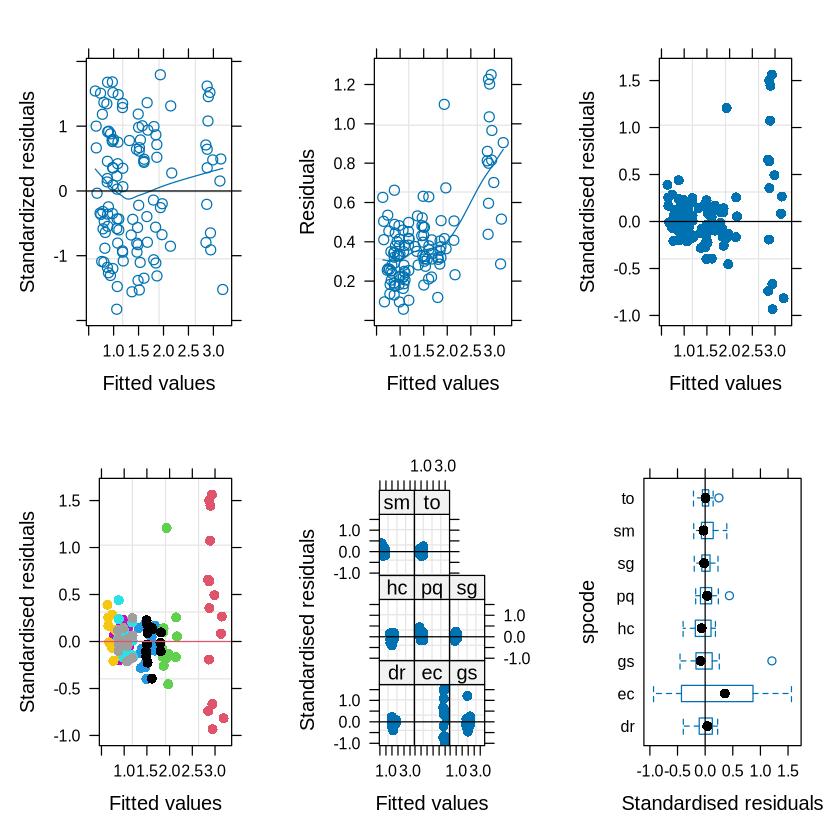

In [29]:
validation_plots(models_q2$n_area_nlme, data = data_for_models, group = "spcode")

## Nodule weight

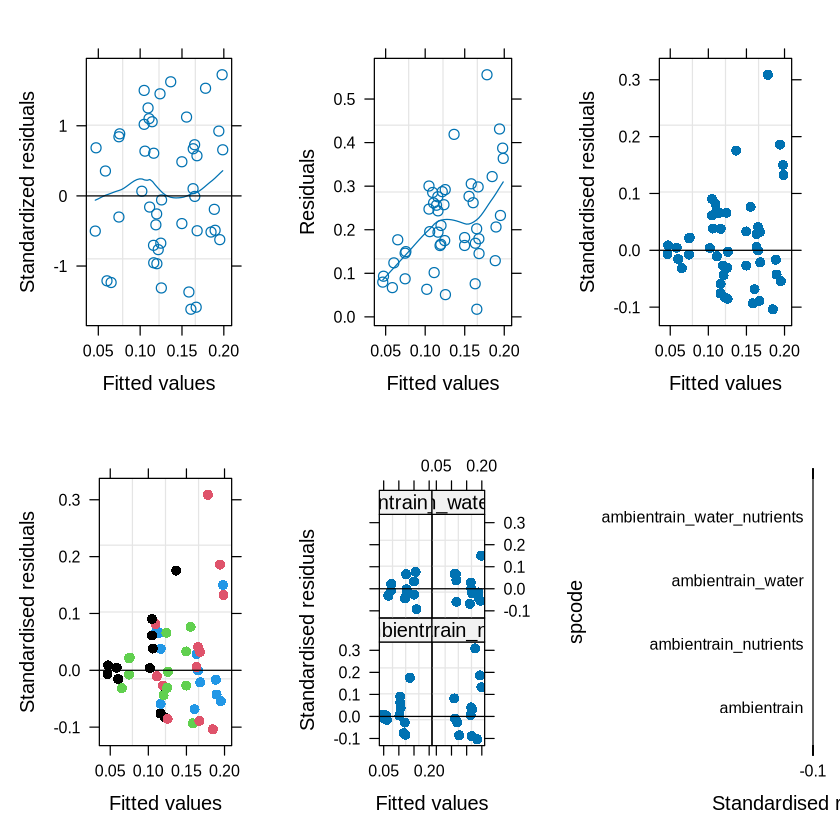

In [30]:
validation_plots(models_q2$nodule_weight, data = data_nodules_cleaned, group = "treatment")

## Nodule count

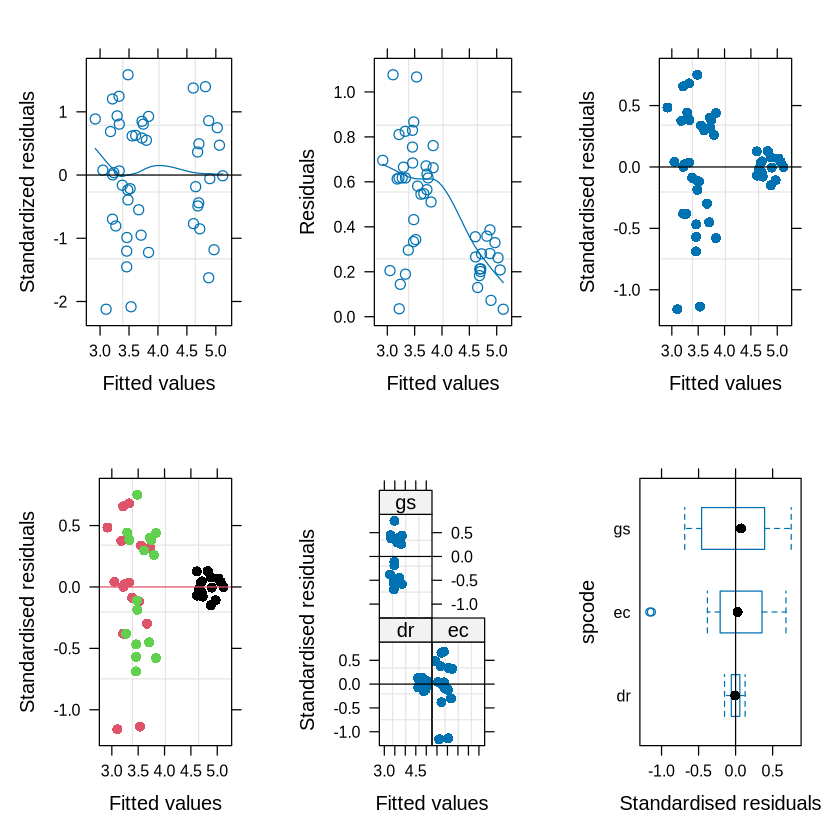

In [31]:
validation_plots(models_q2$nodule_count, data = data_nodules_cleaned, group = 'spcode')

# Model inference

In [32]:
## r2 models
models_q2 %>%
    map(., r2_nakagawa) %>%
    unlist()

nodule_weight.R2_conditional.Conditional R2 
                                 0.41047005 
      nodule_weight.R2_marginal.Marginal R2 
                                 0.13936146 
 nodule_count.R2_conditional.Conditional R2 
                                 0.99210949 
       nodule_count.R2_marginal.Marginal R2 
                                 0.05918329 
     wue_nlme.R2_conditional.Conditional R2 
                                 0.90103593 
           wue_nlme.R2_marginal.Marginal R2 
                                 0.83952518 
      wue_log.R2_conditional.Conditional R2 
                                 0.71998192 
            wue_log.R2_marginal.Marginal R2 
                                 0.55826929 
    pnue_nlme.R2_conditional.Conditional R2 
                                 0.54152938 
          pnue_nlme.R2_marginal.Marginal R2 
                                 0.25716702 
     pnue_log.R2_conditional.Conditional R2 
                                 0.49404988 
           pnue_log.R2_marginal.Marginal R2 
                                 0.19551512 
  n_area_nlme.R2_conditional.Conditional R2 
                                 0.85290420 
        n_area_nlme.R2_marginal.Marginal R2 
                                 0.50937974 
   n_area_log.R2_conditional.Conditional R2 
                                 0.86655501 
         n_area_log.R2_marginal.Marginal R2 
                                 0.58167864 
          sla.R2_conditional.Conditional R2 
                                 0.58102161 
                sla.R2_marginal.Marginal R2 
                                 0.16972856 
           gs.R2_conditional.Conditional R2 
                                 0.46868890 
                 gs.R2_marginal.Marginal R2 
                                 0.39313270 
         amax.R2_conditional.Conditional R2 
                                 0.94110209 
               amax.R2_marginal.Marginal R2 
                                 0.49634927

In [33]:
## r2 models
models_q2 %>%
    map(., AIC) %>%
    unlist()

nodule_weight  nodule_count      wue_nlme       wue_log     pnue_nlme 
   -65.217479     62.790846    302.027069    124.711544   1048.374634 
     pnue_log   n_area_nlme    n_area_log           sla            gs 
    85.397367     88.499042     -2.973373   -925.487312   -159.109494 
         amax 
   483.008695

## Anova tables

In [34]:
#map(models_q2, ~Anova(.x, type = "III", test.statistic = c("F")))

In [35]:
map(models_q2, ~anova.lme(.x, type = "marginal"))

,numDF,denDF,F-value,p-value
,<int>,<dbl>,<dbl>,<dbl>
(Intercept),1,41,3.298145,0.076675263
treatment,3,41,4.623260,0.007088638
init_height,1,41,1.375516,0.247635561
,numDF,denDF,F-value,p-value
,<int>,<dbl>,<dbl>,<dbl>
(Intercept),1,41,27.527073,5.056819e-06
treatment,3,41,11.330325,1.515061e-05
init_height,1,41,5.359407,2.569362e-02
,numDF,denDF,F-value,p-value


## Post-Hoc: Tukey's test

### Maximal photosynthesis

In [ ]:
as_tibble(emmeans(models_q2$amax,
        pairwise ~ treatment*nfixer,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable()

In [ ]:
# Treatment effects
emmeans_table_tidy(models_q2$amax,
                        formula = "treatment|nfixer",
                        grouping_var = "nfixer")

### Water Use Efficiency

In [ ]:
as_tibble(emmeans(models_q2$wue_log,
        pairwise ~ treatment*nfixer,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable() 

In [ ]:
# Treatment effects
emmeans_table_tidy(models_q2$wue_log,
                        formula = "treatment|nfixer",
                        grouping_var = "nfixer")

In [ ]:
as_tibble(emmeans(models_q2$wue_log,
        pairwise ~ nfixer,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable()

In [ ]:
# Treatment effects
as.data.frame(emmeans::emmeans(models_q2$wue_log,
                                specs = pairwise ~nfixer,
                                type = "response",
                                adjust = "tukey")$emmeans) %>%

        janitor::clean_names() %>%
        dplyr::select(response, everything(),
                        # Remove variables
                      -c(df, lower_cl, upper_cl, se)) %>%

        # Rename response to emmean, this is done when models is log
        dplyr::rename_all(funs(stringr::str_replace_all(., "response", "emmean"))) %>%

        # Calculate % difference between control and variable, this assume that
        # that first name is the control

        dplyr::mutate(difference = ((emmean - first(emmean))),
               perc_difference =((emmean - first(emmean) )/first(emmean))*100) %>%

        dplyr::mutate_if(is.numeric, round, 3)

### Stomatal Conductance

In [ ]:
as_tibble(emmeans(models_q2$gs,
        pairwise ~ treatment,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable() 

In [ ]:
# Treatment effects
emmeans_table_tidy(models_q2$gs,
                        formula = "treatment",
                        )

### PNUE

In [ ]:
as_tibble(emmeans(models_q2$pnue_log,
        pairwise ~ treatment,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable()

In [ ]:
# Treatment effects
emmeans_table_tidy(models_q2$pnue_log,
                        formula = "treatment",
                        )

### Nitrogen concentration per unit of area

In [ ]:
as_tibble(emmeans(models_q2$n_area_log,
        pairwise ~ treatment,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable()

In [ ]:
# Treatment effects
emmeans_table_tidy(models_q2$n_area_log,
                        formula = "treatment",
                        )

In [ ]:
as_tibble(emmeans(models_q2$n_area_log,
        pairwise ~ nfixer,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable()

In [ ]:
# Treatment effects
as.data.frame(emmeans::emmeans(models_q2$n_area_log,
                                specs = pairwise ~nfixer,
                                type = "response",
                                adjust = "tukey")$emmeans) %>%

        janitor::clean_names() %>%
        dplyr::select(response, everything(),
                        # Remove variables
                      -c(df, lower_cl, upper_cl, se)) %>%

        # Rename response to emmean, this is done when models is log
        dplyr::rename_all(funs(stringr::str_replace_all(., "response", "emmean"))) %>%

        # Calculate % difference between control and variable, this assume that
        # that first name is the control

        dplyr::mutate(difference = ((emmean - first(emmean))),
               perc_difference =((emmean - first(emmean) )/first(emmean))*100) %>%

        dplyr::mutate_if(is.numeric, round, 3)

### Nodule weight

In [36]:
as_tibble(emmeans(models_q2$nodule_weight,
        pairwise ~ treatment,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable()

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(2:6, round, 6)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”




|contrast                                            |  estimate|       SE| df|   t.ratio|  p.value|
|:---------------------------------------------------|---------:|--------:|--:|---------:|--------:|
|ambientrain - ambientrain_nutrients                 | -0.063102| 0.023122| 41| -2.729080| 0.044304|
|ambientrain - ambientrain_water                     | -0.022670| 0.012938| 41| -1.752270| 0.310721|
|ambientrain - ambientrain_water_nutrients           | -0.060509| 0.019831| 41| -3.051243| 0.020007|
|ambientrain_nutrients - ambientrain_water           |  0.040432| 0.023862| 41|  1.694365| 0.339668|
|ambientrain_nutrients - ambientrain_water_nutrients |  0.002593| 0.026517| 41|  0.097800| 0.999659|
|ambientrain_water - ambientrain_water_nutrients     | -0.037838| 0.020476| 41| -1.847951| 0.266271|

In [ ]:
# Treatment effects
emmeans_table_tidy(models_q2$nodule_weight,
                        formula = "treatment")

### Nodule Count

In [37]:
as_tibble(emmeans(models_q2$nodule_count,
        pairwise ~ treatment,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6)) %>%
        kable()



|contrast                                            |  estimate|       SE| df|   t.ratio|  p.value|
|:---------------------------------------------------|---------:|--------:|--:|---------:|--------:|
|ambientrain - ambientrain_nutrients                 |  0.168648| 0.064247| 41|  2.624984| 0.056480|
|ambientrain - ambientrain_water                     |  0.116467| 0.068880| 41|  1.690864| 0.341466|
|ambientrain - ambientrain_water_nutrients           | -0.185805| 0.062976| 41| -2.950424| 0.025831|
|ambientrain_nutrients - ambientrain_water           | -0.052181| 0.064750| 41| -0.805885| 0.851284|
|ambientrain_nutrients - ambientrain_water_nutrients | -0.354452| 0.063957| 41| -5.542023| 0.000011|
|ambientrain_water - ambientrain_water_nutrients     | -0.302272| 0.068268| 41| -4.427689| 0.000389|

In [38]:
# Treatment effects
emmeans_table_tidy(models_q2$nodule_count,
                        formula = "treatment")

[1] "Formula for pairwise comparisons: "
pairwise ~ treatment
<environment: 0x620203a29a18>


Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


HTML widgets cannot be represented in plain text (need html)

### Boxplots

#### Boxplots traits

In [41]:
# Step done for getting predictions from models for Q2
data_for_predictions <-
    data_for_models %>%

        rownames_to_column("id") %>%

        # Remove unused variables
        dplyr::select(id, spcode, treatment, nfixer, init_height)

In [42]:
string <- c("models_q2")

data_pred_traits <-

        # Get models prediction
        gather_predictions(data_for_predictions ,

                           # Return predictions
                            models_q2$amax,
                            models_q2$sla,
                            models_q2$gs,
                            models_q2$wue_log,
                            models_q2$pnue_log,
                            models_q2$n_area_log

                            ) %>%

        pivot_wider(names_from = model, values_from = pred) %>%
            rename_all(funs(

                # rename columns
                stringr::str_to_lower(.) %>%
                stringr::str_replace(., c(string),"pred_") %>%

                # Remove dollar sing
                gsub("\\$", "", .)
                )) %>%

        # Back transform log variables
        mutate(pred_wue = exp(pred_wue_log),
                pred_n_area = exp(pred_n_area_log),
                pred_pnue =  exp(pred_pnue_log),

            ) %>%

        # Remove log predictions and init height
        dplyr::select(-c(init_height, pred_wue_log, pred_n_area_log))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [43]:
# Generate plot combinations

vars_q2_interaction <-

  crossing(

    # Get all numeric variables to plot (all y)
    as_tibble(t(combn(dplyr::select(data_pred_traits, where(is.numeric)) %>% names, 1))),

    # Select factor variables to plot
    x_axis_var = dplyr::select(data_pred_traits, nfixer) %>%  names,
    group_var = dplyr::select(data_pred_traits, treatment) %>%  names) %>%

    filter(V1 %in% c('pred_amax', 'pred_wue'))

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


[1] 24.076
[1] 7.034


[[1]]

[[2]]


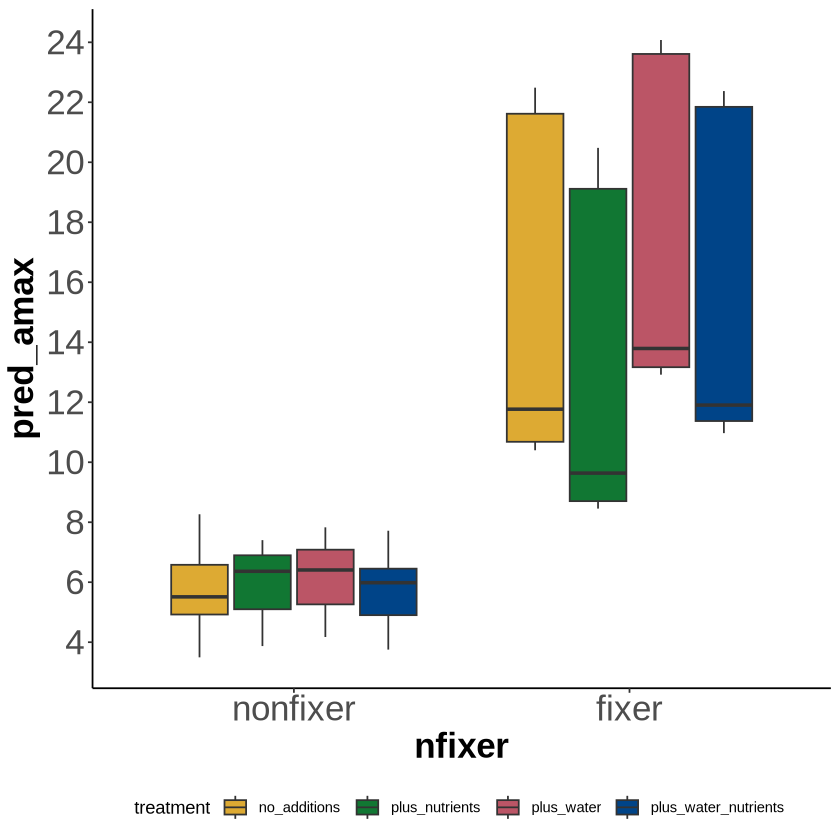

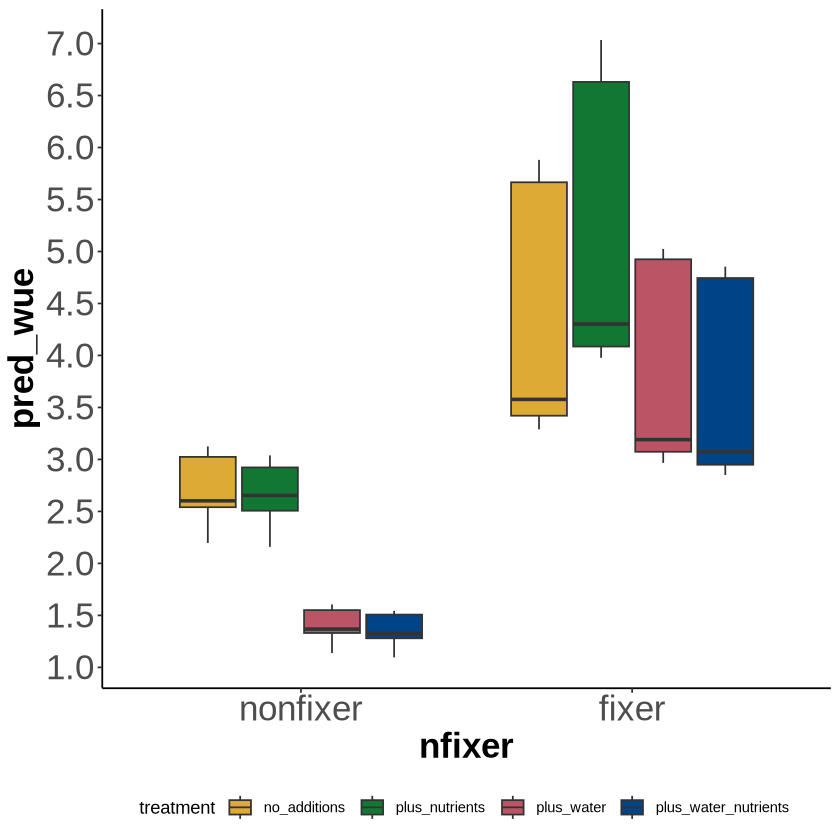

In [44]:
vars_q2_interaction %>%
      # Gererate plots
      pmap( ~ boxplot_plot_pmap(data = data_pred_traits,
                                y = !!sym(..1), x = !!sym(..2),
                                fill = !!sym(..3)))

In [45]:
vars_q2_treatment <-

  crossing(

    # Get all numeric variables to plot (all y)
    as_tibble(t(combn(dplyr::select(data_pred_traits, where(is.numeric)) %>% names, 1))),

    # Select factor variables to plot
    x_axis_var = dplyr::select(data_pred_traits, treatment) %>%  names,
    group_var = dplyr::select(data_pred_traits, treatment) %>%  names) %>%

    filter(V1 %in% c('pred_gs', 'pred_n_area', 'pred_pnue' ))

[1] 0.359
[1] 3.399
[1] 116.964


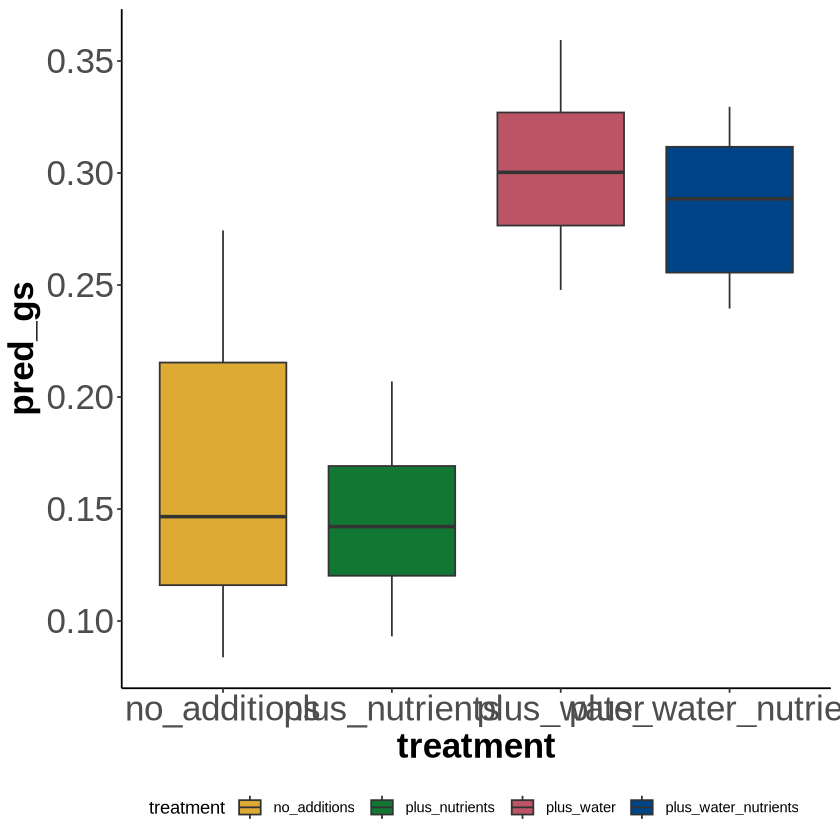

[[1]]

[[2]]

[[3]]


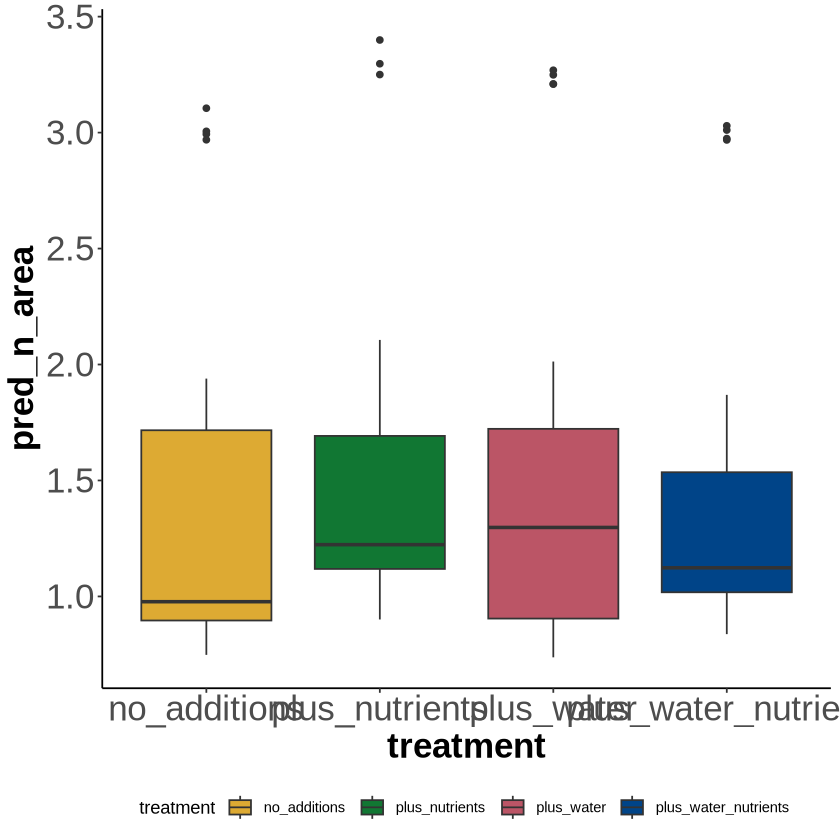

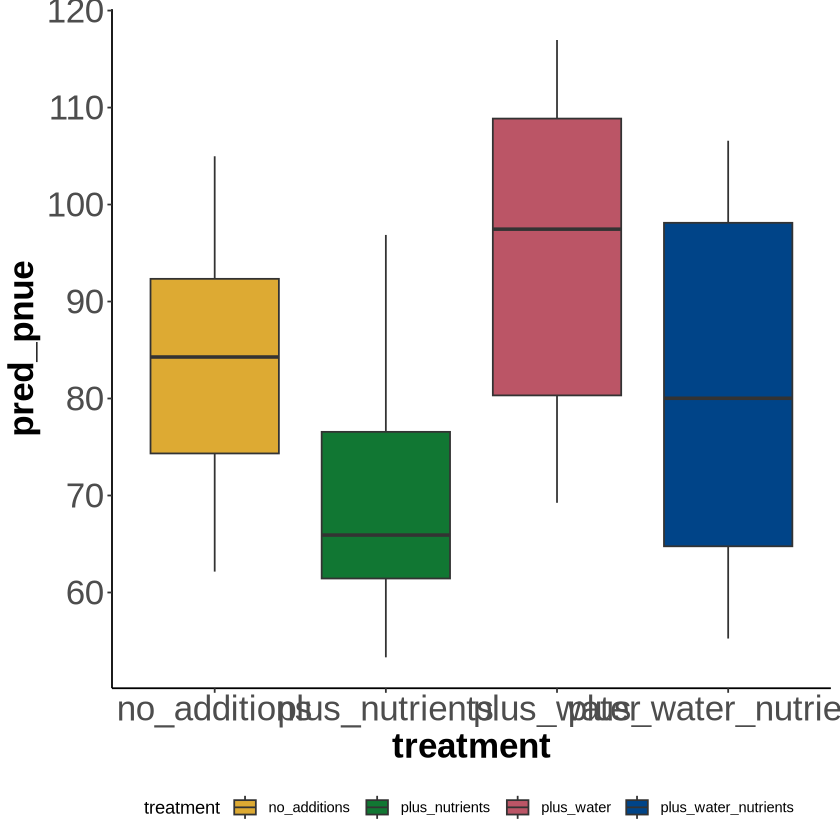

In [46]:
vars_q2_treatment %>%
      # Gererate plots
      pmap( ~ boxplot_plot_pmap(data = data_pred_traits,
                                y = !!sym(..1), x = !!sym(..2),
                                fill = !!sym(..3)))

#### Boxplots Nodules

In [47]:
data_for_nodule_predictions <- 
        data_nodules_cleaned %>%

        rownames_to_column("id") %>%

        # Remove unused variables
        dplyr::select(id, spcode, treatment, init_height)

In [49]:
string <- c("models_q2")

data_pred_nodules <-

        # Get models prediction
        gather_predictions(data_for_nodule_predictions,

                           # Return predictions
                            models_q2$nodule_count,
                            models_q2$nodule_weight) %>%    

        pivot_wider(names_from = model, values_from = pred) %>%
            rename_all(funs(

                # rename columns
                stringr::str_to_lower(.) %>%
                stringr::str_replace(., c(string),"pred_") %>%

                # Remove dollar sing
                gsub("\\$", "", .)
                )) %>% 
        # Remove log predictions and init height
        dplyr::select(-c(init_height))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [50]:
# Generate plot combinations

vars_q2_nodules <-

  crossing(

    # Get all numeric variables to plot (all y)
    as_tibble(t(combn(dplyr::select(data_pred_nodules, where(is.numeric)) %>% names, 1))),

    # Select factor variables to plot
    x_axis_var = dplyr::select(data_pred_nodules, treatment) %>%  names,
    group_var = dplyr::select(data_pred_nodules, treatment) %>%  names) 

[1] 5.119
[1] 0.199


[[1]]

[[2]]


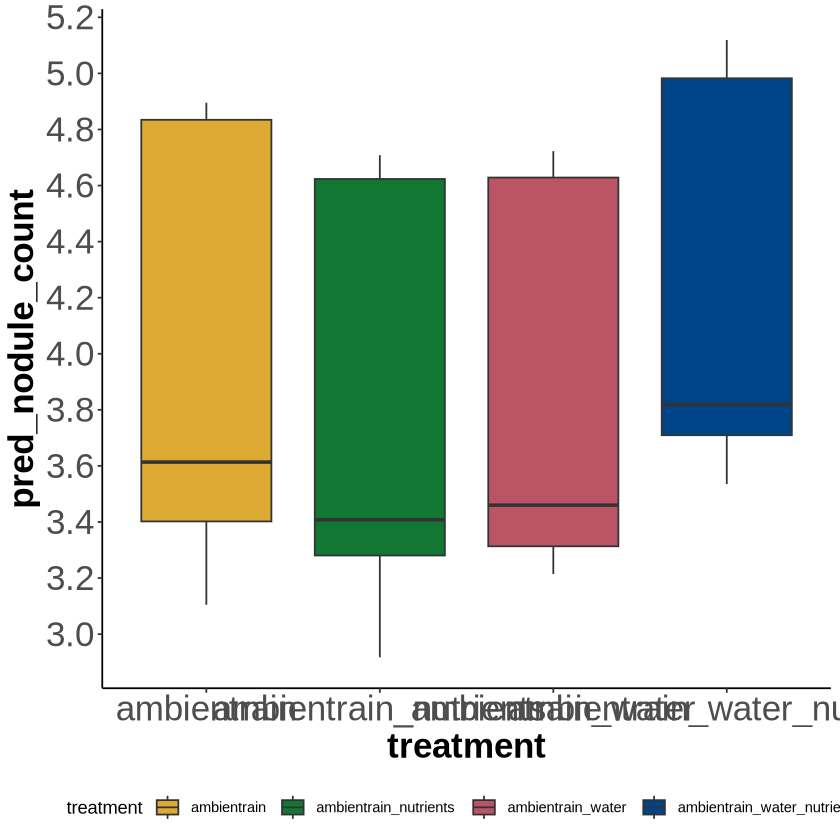

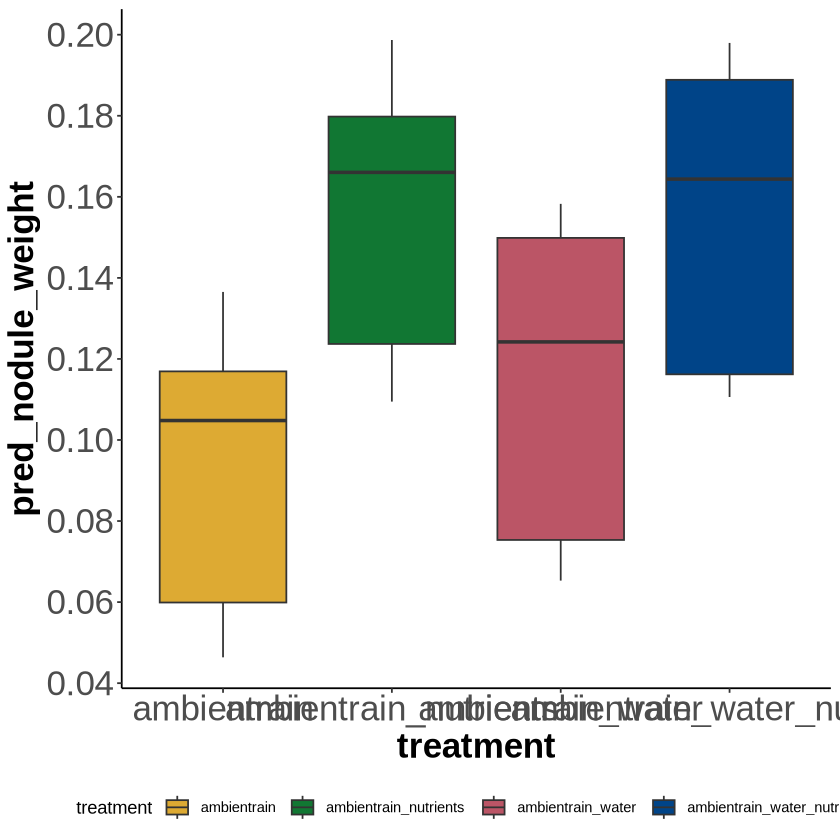

In [51]:
vars_q2_nodules %>%
      # Gererate plots
      pmap( ~ boxplot_plot_pmap(data = data_pred_nodules,
                                y = !!sym(..1), x = !!sym(..2),
                                fill = !!sym(..3)))